# Stock Prices Predictor

# New Section

In [1]:
# !pip install tensorflow
# !pip install tf-nightly
# !pip install --upgrade keras
# !pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [3]:
stock_data = pd.read_csv('./TATAMOTORS.csv')
stock_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-24,410.000000,424.000000,410.000000,422.149994,420.838379,30197475
1,2023-01-25,423.750000,427.250000,417.700012,419.049988,417.747986,22975581
2,2023-01-27,438.000000,453.399994,435.149994,445.600006,444.215515,63360467
3,2023-01-30,445.600006,450.000000,437.649994,443.649994,442.271576,18316743
4,2023-01-31,443.700012,454.799988,440.899994,452.100006,450.695313,25154475


<function matplotlib.pyplot.show(close=None, block=None)>

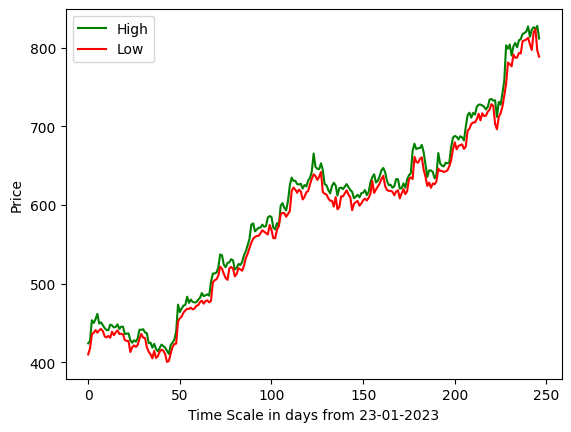

In [4]:
y_high = stock_data['High']
y_low = stock_data['Low']
plt.plot(y_high.index,y_high,label='High',color='g')
plt.plot(y_low.index,y_low,label='Low',color= 'r')
plt.xlabel('Time Scale in days from 23-01-2023')
plt.ylabel('Price')
plt.legend()
plt.show

In [5]:
## Data preprocessing

In [6]:
target_y = stock_data['Close']
X_feat = stock_data.iloc[:,1:3]
X_feat.head()

,Open,High
0,410.000000,424.000000
1,423.750000,427.250000
2,438.000000,453.399994
3,445.600006,450.000000
4,443.700012,454.799988


In [7]:
## standardized the data 
sc = StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
stock_data_ft = pd.DataFrame(columns=X_feat.columns , data=X_ft , index = X_feat.index)
stock_data_ft.head()

,Open,High
0,-1.583731,-1.499156
1,-1.460754,-1.470272
2,-1.333305,-1.237871
3,-1.265332,-1.268088
4,-1.282325,-1.225429


In [8]:
### define lstm split function

def lstm_split(data,n_steps):
    X, Y = [] , []
    for i in range(len(data)- n_steps +1):
        X.append(data[i: i+ n_steps, :-1])
        Y.append(data[i + n_steps -1, -1])

    return np.array(X) , np.array(Y)

In [9]:
## Train aand Test sets

In [10]:
x1 , y1 = lstm_split(stock_data_ft.values , n_steps =2)

train_split = 0.8
split_idx = int(np.ceil(len(x1)*train_split))
date_index = stock_data_ft.index

x_train ,x_test = x1[:split_idx] , x1[split_idx:]
y_train ,y_test = y1[:split_idx] , y1[split_idx:]

print(x1.shape, x_train.shape , x_test.shape,y_test.shape)



(246, 2, 1) (197, 2, 1) (49, 2, 1) (49,)


In [11]:
## Building  the LSTM model

In [12]:
input_shape = (x_train.shape[1],x_train.shape[2])

lstm = Sequential()
lstm.add(LSTM(64, activation ='relu', return_sequences =True,input_shape = input_shape))
lstm.add(Dropout(0.2))
lstm.add(LSTM(32,activation='relu',return_sequences = True))
lstm.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
lstm.compile(loss= 'mean_squared_error',optimizer = optimizer)
lstm.summary()

c:\Users\nites\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 64)             │     16,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 2, 64)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 2, 32)             │     12,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 2, 1)              │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = lstm.fit(x_train, y_train, epochs =200 , batch_size =4, verbose =2 , shuffle = False)

Epoch 1/200
50/50 - 4s - 87ms/step - loss: 0.6705
Epoch 2/200
50/50 - 0s - 4ms/step - loss: 0.5781
Epoch 3/200
50/50 - 0s - 4ms/step - loss: 0.3266
Epoch 4/200
50/50 - 0s - 7ms/step - loss: 0.2085
Epoch 5/200
50/50 - 1s - 13ms/step - loss: 0.1757
Epoch 6/200
50/50 - 0s - 8ms/step - loss: 0.1539
Epoch 7/200
50/50 - 1s - 12ms/step - loss: 0.1194
Epoch 8/200
50/50 - 0s - 5ms/step - loss: 0.0741
Epoch 9/200
50/50 - 0s - 5ms/step - loss: 0.0392
Epoch 10/200
50/50 - 0s - 5ms/step - loss: 0.0488
Epoch 11/200
50/50 - 0s - 5ms/step - loss: 0.0289
Epoch 12/200
50/50 - 0s - 4ms/step - loss: 0.0265
Epoch 13/200
50/50 - 0s - 5ms/step - loss: 0.0215
Epoch 14/200
50/50 - 0s - 7ms/step - loss: 0.0217
Epoch 15/200
50/50 - 0s - 8ms/step - loss: 0.0174
Epoch 16/200
50/50 - 0s - 6ms/step - loss: 0.0173
Epoch 17/200
50/50 - 0s - 7ms/step - loss: 0.0170
Epoch 18/200
50/50 - 0s - 5ms/step - loss: 0.0179
Epoch 19/200
50/50 - 0s - 5ms/step - loss: 0.0196
Epoch 20/200
50/50 - 0s - 5ms/step - loss: 0.0170
Epoch 

In [14]:
y_pred_train = lstm.predict(x_train)
y_pred_test = lstm.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [15]:

# Assuming you want to use the predictions at time step 0
y_pred_2d_train = y_pred_train[:,0,0]
y_pred_2d_test = y_pred_test[:,0,0]

rmse = np.sqrt(mean_squared_error(y_test, y_pred_2d_test))
mape = mean_absolute_error(y_test, y_pred_2d_test)
print(rmse)
print(mape)

0.3926813156751078
0.2835953271562214


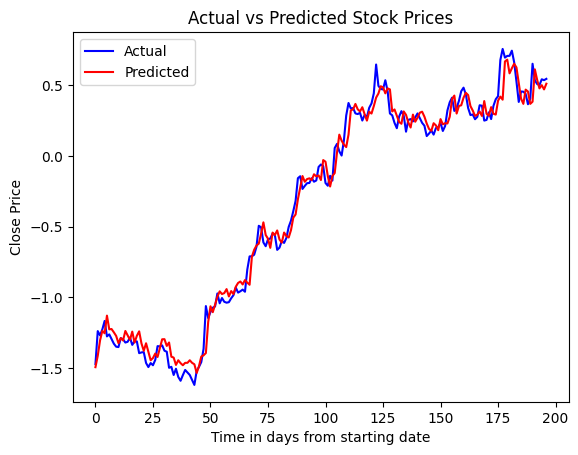

In [16]:
plt.plot(y_train, label='Actual', color='blue')

# Plotting the predicted values for trained data
plt.plot(y_pred_2d_train, label='Predicted', color='red')

plt.xlabel('Time in days from starting date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

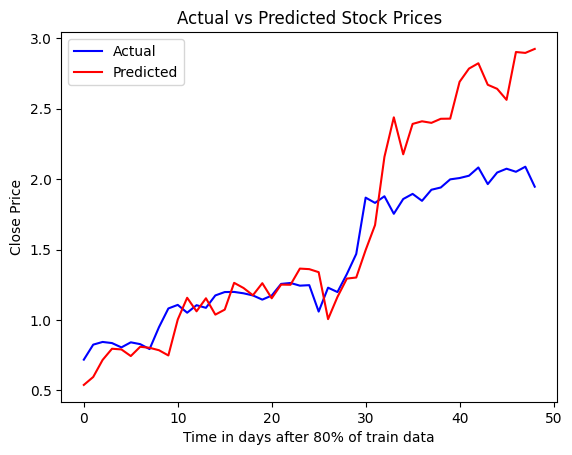

In [17]:
plt.plot(y_test, label='Actual', color='blue')

# Plotting the predicted for test values
plt.plot(y_pred_2d_test, label='Predicted', color='red')

plt.xlabel('Time in days after 80% of train data')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()